In [ ]:
# ========================================
# 1. IMPORTS AND CONFIGURATION
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Data processing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFE, mutual_info_classif

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Metrics and evaluation
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, confusion_matrix, classification_report,
                           roc_curve, precision_recall_curve, average_precision_score)

# Imbalanced data handling
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Model interpretation
from sklearn.inspection import permutation_importance
import shap

# Utilities
import joblib
import pickle
from datetime import datetime
import os
from typing import Dict, List, Tuple, Any
import logging

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('credit_risk_model.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

In [ ]:
# ========================================
# 2. CONFIGURATION AND CONSTANTS
# ========================================

class Config:
    """Configuration class for model parameters"""
    RANDOM_STATE = 42
    TEST_SIZE = 0.2
    VAL_SIZE = 0.1
    CV_FOLDS = 5

    # Business metrics weights
    FN_COST = 5  # Cost of false negative (approving bad loan) is 5x
    FP_COST = 1  # Cost of false positive (rejecting good loan)

    # Model thresholds
    PROBABILITY_THRESHOLD = 0.3  # Lower threshold = more conservative

    # Feature engineering parameters
    CORRELATION_THRESHOLD = 0.9
    VARIANCE_THRESHOLD = 0.01

    # File paths
    MODEL_PATH = 'models/'
    RESULTS_PATH = 'results/'
    DATA_PATH = 'data/'

# Create directories if they don't exist
for path in [Config.MODEL_PATH, Config.RESULTS_PATH, Config.DATA_PATH]:
    os.makedirs(path, exist_ok=True)

In [ ]:
# ========================================
# 3. DATA LOADING AND INITIAL EXPLORATION
# ========================================

def load_german_credit_data():
    """
    Load German Credit Dataset from local data/ folder
    This is a standard dataset for credit risk modeling
    """
    # Path to local file
    file_path = os.path.join(Config.DATA_PATH, 'german.data')

    # Correct column names for German Credit Dataset (20 attributes + 1 class)
    column_names = [
        'checking_status',      # Status of existing checking account (A11, A12, A13, A14)
        'duration',            # Duration in month (numerical)
        'credit_history',      # Credit history (A30, A31, A32, A33, A34)
        'purpose',            # Purpose (A40, A41, A42, A43, A44, A45, A46, A47, A48, A49, A410)
        'credit_amount',      # Credit amount (numerical)
        'savings_status',     # Savings account/bonds (A61, A62, A63, A64, A65)
        'employment',         # Present employment since (A71, A72, A73, A74, A75)
        'installment_rate',   # Installment rate in percentage of disposable income (1, 2, 3, 4)
        'personal_status',    # Personal status and sex (A91, A92, A93, A94, A95)
        'other_parties',      # Other debtors / guarantors (A101, A102, A103)
        'residence_since',    # Present residence since (numerical: 1, 2, 3, 4)
        'property_magnitude', # Property (A121, A122, A123, A124)
        'age',               # Age in years (numerical)
        'other_payment_plans', # Other installment plans (A141, A142, A143)
        'housing',           # Housing (A151, A152, A153)
        'existing_credits',  # Number of existing credits at this bank (numerical: 1, 2, 3, 4)
        'job',              # Job (A171, A172, A173, A174)
        'num_dependents',   # Number of people being liable to provide maintenance for (numerical: 1, 2)
        'own_telephone',    # Telephone (A191, A192)
        'foreign_worker',   # Foreign worker (A201, A202)
        'class'            # Classification (1=good credit, 2=bad credit)
    ]

    try:
        # Check if file exists
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Data file not found at: {file_path}")

        # Load the dataset - German credit data is space-separated
        df = pd.read_csv(file_path, sep=' ', names=column_names, header=None)
        logger.info(f"Successfully loaded German Credit data from local file: {df.shape}")

        # Convert target variable: 1=good credit (0), 2=bad credit (1)
        df['risk'] = df['class'].map({1: 0, 2: 1})
        df.drop('class', axis=1, inplace=True)

        # Basic data validation
        logger.info(f"Dataset shape: {df.shape}")
        logger.info(f"Features: {df.shape[1] - 1}")  # Exclude target
        logger.info(f"Default rate: {df['risk'].mean():.2%}")
        logger.info(f"Missing values: {df.isnull().sum().sum()}")

        # Print first few rows for verification
        logger.info("First 3 rows:")
        logger.info(f"\n{df.head(3)}")

        return df

    except FileNotFoundError as e:
        logger.error(f"File not found: {e}")
        logger.error("Please ensure 'german.data' is placed in the 'data/' directory")
        raise

    except Exception as e:
        logger.error(f"Error loading data from local file: {e}")
        raise

def validate_german_credit_data(df):
    """
    Validate that the loaded data matches German Credit Dataset specifications
    """
    expected_shape = (1000, 21)  # 1000 samples, 20 features + 1 target (risk)

    # Check shape
    if df.shape != expected_shape:
        logger.warning(f"Unexpected shape: {df.shape}, expected: {expected_shape}")
    else:
        logger.info(f"Shape validation passed: {df.shape}")

    # Check target distribution (approximately 70% good, 30% bad)
    target_dist = df['risk'].value_counts(normalize=True)
    logger.info(f"Target distribution: Good credit (0): {target_dist[0]:.1%}, Bad credit (1): {target_dist[1]:.1%}")

    # Verify expected distribution (should be around 70%/30%)
    if not (0.65 <= target_dist[0] <= 0.75):
        logger.warning(f"Unexpected target distribution. Expected ~70% good credit, got {target_dist[0]:.1%}")

    # Check for missing values (German Credit has no missing values)
    missing_count = df.isnull().sum().sum()
    if missing_count > 0:
        logger.warning(f"Found {missing_count} missing values (unexpected for German Credit dataset)")
    else:
        logger.info("No missing values found (as expected)")

    # Check numerical columns ranges
    numerical_validations = {
        'duration': {'min': 4, 'max': 72, 'type': 'months'},
        'credit_amount': {'min': 250, 'max': 18424, 'type': 'DM'},
        'age': {'min': 19, 'max': 75, 'type': 'years'},
        'installment_rate': {'min': 1, 'max': 4, 'type': 'rate'},
        'residence_since': {'min': 1, 'max': 4, 'type': 'years'},
        'existing_credits': {'min': 1, 'max': 4, 'type': 'count'},
        'num_dependents': {'min': 1, 'max': 2, 'type': 'count'}
    }

    logger.info("Numerical feature validation:")
    for col, validation in numerical_validations.items():
        if col in df.columns:
            actual_min, actual_max = df[col].min(), df[col].max()
            expected_min, expected_max = validation['min'], validation['max']

            logger.info(f"  {col}: [{actual_min}, {actual_max}] (expected: [{expected_min}, {expected_max}])")

            if actual_min < expected_min or actual_max > expected_max:
                logger.warning(f"    Range outside expected bounds for {col}")

    # Check categorical columns have expected codes
    categorical_validations = {
        'checking_status': {'codes': ['A11', 'A12', 'A13', 'A14'], 'count': 4},
        'credit_history': {'codes': ['A30', 'A31', 'A32', 'A33', 'A34'], 'count': 5},
        'purpose': {'codes': ['A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A48', 'A49', 'A410'], 'count': 10},
        'savings_status': {'codes': ['A61', 'A62', 'A63', 'A64', 'A65'], 'count': 5},
        'employment': {'codes': ['A71', 'A72', 'A73', 'A74', 'A75'], 'count': 5},
        'own_telephone': {'codes': ['A191', 'A192'], 'count': 2},
        'foreign_worker': {'codes': ['A201', 'A202'], 'count': 2}
    }

    logger.info("Categorical feature validation:")
    for col, validation in categorical_validations.items():
        if col in df.columns:
            unique_values = sorted(df[col].unique())
            expected_count = validation['count']
            actual_count = len(unique_values)

            logger.info(f"  {col}: {actual_count} unique values (expected: {expected_count})")
            logger.info(f"    Sample values: {unique_values[:5]}")

            if actual_count != expected_count:
                logger.warning(f"    Unexpected number of categories for {col}")

    logger.info("Data validation completed")
    return True

def explore_german_credit_features(df):
    """
    Enhanced exploration of German Credit Dataset features with proper categorization
    """
    print("\n" + "="*80)
    print("GERMAN CREDIT DATASET - FEATURE OVERVIEW")
    print("="*80)

    # Define feature types based on actual dataset structure
    numerical_features = ['duration', 'credit_amount', 'age', 'installment_rate',
                         'residence_since', 'existing_credits', 'num_dependents']

    categorical_features = ['checking_status', 'credit_history', 'purpose', 'savings_status',
                           'employment', 'personal_status', 'other_parties', 'property_magnitude',
                           'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']

    # Numerical features analysis
    print(f"\nNumerical Features ({len(numerical_features)}):")
    print("-" * 50)
    for col in numerical_features:
        if col in df.columns:
            stats = df[col].describe()
            print(f"  {col}:")
            print(f"    Range: [{stats['min']:.0f}, {stats['max']:.0f}]")
            print(f"    Mean: {stats['mean']:.1f}, Median: {stats['50%']:.1f}")
            print(f"    Std: {stats['std']:.1f}")

    # Categorical features analysis
    print(f"\nCategorical Features ({len(categorical_features)}):")
    print("-" * 50)
    for col in categorical_features:
        if col in df.columns:
            unique_count = df[col].nunique()
            unique_values = sorted(df[col].unique())
            value_counts = df[col].value_counts()

            print(f"  {col}:")
            print(f"    Categories: {unique_count}")
            print(f"    Values: {unique_values}")
            print(f"    Most common: {value_counts.index[0]} ({value_counts.iloc[0]} cases)")

    # Target variable analysis
    print(f"\nTarget Variable Analysis:")
    print("-" * 30)
    risk_counts = df['risk'].value_counts().sort_index()
    total = len(df)

    print(f"  Good Credit (0): {risk_counts[0]} cases ({risk_counts[0]/total:.1%})")
    print(f"  Bad Credit (1):  {risk_counts[1]} cases ({risk_counts[1]/total:.1%})")

    # Feature-target relationship (quick overview)
    print(f"\nQuick Risk Analysis by Key Features:")
    print("-" * 40)

    key_features = ['checking_status', 'credit_history', 'purpose']
    for feature in key_features:
        if feature in df.columns:
            risk_by_feature = df.groupby(feature)['risk'].agg(['count', 'mean']).round(3)
            print(f"\n  {feature}:")
            for idx, row in risk_by_feature.iterrows():
                print(f"    {idx}: {row['count']} cases, {row['mean']:.1%} default rate")

    print("="*80)

In [ ]:
# ========================================
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# ========================================

class CreditRiskEDA:
    """Comprehensive EDA for German Credit Risk data"""

    def __init__(self, df: pd.DataFrame):
        self.df = df

        # Define feature types explicitly for German Credit dataset
        self.numerical_cols = [
            'duration', 'credit_amount', 'age', 'installment_rate',
            'residence_since', 'existing_credits', 'num_dependents'
        ]

        self.categorical_cols = [
            'checking_status', 'credit_history', 'purpose', 'savings_status',
            'employment', 'personal_status', 'other_parties', 'property_magnitude',
            'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker'
        ]

        # Filter columns that actually exist in the dataframe
        self.numerical_cols = [col for col in self.numerical_cols if col in df.columns]
        self.categorical_cols = [col for col in self.categorical_cols if col in df.columns]

        # Create readable names for better visualization
        self.feature_names = {
            'checking_status': 'Checking Account Status',
            'duration': 'Duration (months)',
            'credit_history': 'Credit History',
            'purpose': 'Loan Purpose',
            'credit_amount': 'Credit Amount',
            'savings_status': 'Savings Account',
            'employment': 'Employment Since',
            'installment_rate': 'Installment Rate (%)',
            'personal_status': 'Personal Status',
            'other_parties': 'Other Debtors/Guarantors',
            'residence_since': 'Residence Since (years)',
            'property_magnitude': 'Property',
            'age': 'Age (years)',
            'other_payment_plans': 'Other Payment Plans',
            'housing': 'Housing',
            'existing_credits': 'Existing Credits',
            'job': 'Job',
            'num_dependents': 'Number of Dependents',
            'own_telephone': 'Own Telephone',
            'foreign_worker': 'Foreign Worker'
        }

    def basic_info(self):
        """Display basic information about the dataset"""
        print("=" * 80)
        print("GERMAN CREDIT DATASET INFORMATION")
        print("=" * 80)
        print(f"Shape: {self.df.shape}")
        print(f"Memory Usage: {self.df.memory_usage().sum() / 1024**2:.2f} MB")

        print(f"\nTarget Distribution (Risk):")
        risk_dist = self.df['risk'].value_counts().sort_index()
        total = len(self.df)
        print(f"  Good Credit (0): {risk_dist[0]} ({risk_dist[0]/total:.1%})")
        print(f"  Bad Credit (1):  {risk_dist[1]} ({risk_dist[1]/total:.1%})")

        # Check for missing values
        missing_values = self.df.isnull().sum()
        if missing_values.sum() > 0:
            print("\nMissing Values:")
            print(missing_values[missing_values > 0])
        else:
            print("\nMissing Values: None (as expected for German Credit dataset)")

        print(f"\nFeature Types:")
        print(f"  Numerical: {len(self.numerical_cols)}")
        print(f"  Categorical: {len(self.categorical_cols)}")

        # Display feature categories
        print(f"\nNumerical Features: {self.numerical_cols}")
        print(f"\nCategorical Features: {self.categorical_cols[:5]}...")  # Show first 5

    def statistical_summary(self):
        """Generate statistical summary with enhanced insights"""
        print("\n" + "=" * 80)
        print("STATISTICAL SUMMARY - NUMERICAL FEATURES")
        print("=" * 80)

        if not self.numerical_cols:
            print("No numerical features found!")
            return

        summary = self.df[self.numerical_cols].describe().T
        summary['skewness'] = self.df[self.numerical_cols].skew()
        summary['kurtosis'] = self.df[self.numerical_cols].kurtosis()

        # Add interpretable columns
        summary['range'] = summary['max'] - summary['min']
        summary['cv'] = summary['std'] / summary['mean']  # Coefficient of variation

        print(summary.round(2))

        # Identify potentially problematic features
        print("\n" + "-" * 40)
        print("FEATURE CHARACTERISTICS:")
        print("-" * 40)

        for col in self.numerical_cols:
            skew = summary.loc[col, 'skewness']
            cv = summary.loc[col, 'cv']

            characteristics = []
            if abs(skew) > 1:
                characteristics.append(f"highly skewed ({skew:.2f})")
            elif abs(skew) > 0.5:
                characteristics.append(f"moderately skewed ({skew:.2f})")

            if cv > 1:
                characteristics.append(f"high variability (CV: {cv:.2f})")
            elif cv < 0.1:
                characteristics.append(f"low variability (CV: {cv:.2f})")

            if characteristics:
                print(f"  {col}: {', '.join(characteristics)}")

    def plot_distributions(self):
        """Plot distributions of numerical features with risk comparison"""
        if not self.numerical_cols:
            print("No numerical features to plot!")
            return

        n_cols = 3
        n_rows = (len(self.numerical_cols) + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
        if n_rows == 1:
            axes = [axes] if len(self.numerical_cols) == 1 else axes
        else:
            axes = axes.flatten()

        colors = ['skyblue', 'salmon']
        labels = ['Good Credit (0)', 'Bad Credit (1)']

        for idx, col in enumerate(self.numerical_cols):
            ax = axes[idx]

            # Plot distribution for each risk class
            for risk_val, color, label in zip([0, 1], colors, labels):
                data = self.df[self.df['risk'] == risk_val][col]
                ax.hist(data, alpha=0.6, label=label, bins=20, color=color, density=True)

            # Add statistics
            mean_good = self.df[self.df['risk'] == 0][col].mean()
            mean_bad = self.df[self.df['risk'] == 1][col].mean()

            ax.axvline(mean_good, color='blue', linestyle='--', alpha=0.8, label=f'Mean Good: {mean_good:.1f}')
            ax.axvline(mean_bad, color='red', linestyle='--', alpha=0.8, label=f'Mean Bad: {mean_bad:.1f}')

            readable_name = self.feature_names.get(col, col)
            ax.set_title(f'Distribution: {readable_name}')
            ax.set_xlabel(readable_name)
            ax.set_ylabel('Density')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)

        # Remove empty subplots
        for idx in range(len(self.numerical_cols), len(axes)):
            fig.delaxes(axes[idx])

        plt.suptitle('Numerical Feature Distributions by Credit Risk', fontsize=16)
        plt.tight_layout()
        plt.savefig(f'{Config.RESULTS_PATH}feature_distributions.png', dpi=300, bbox_inches='tight')
        plt.show()

    def correlation_analysis(self):
        """Analyze correlations between numerical features and target"""
        if not self.numerical_cols:
            print("No numerical features for correlation analysis!")
            return

        # Create correlation matrix including target
        corr_features = self.numerical_cols + ['risk']
        corr_matrix = self.df[corr_features].corr()

        # Plot correlation heatmap
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(corr_matrix), k=1)

        sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f',
                   cmap='RdBu_r', center=0, square=True, linewidths=0.5,
                   cbar_kws={"shrink": .8})
        plt.title('Feature Correlation Matrix (including Risk Target)', fontsize=14)
        plt.tight_layout()
        plt.savefig(f'{Config.RESULTS_PATH}correlation_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Feature-target correlations
        print("\n" + "=" * 60)
        print("FEATURE-TARGET CORRELATIONS")
        print("=" * 60)
        target_corr = corr_matrix['risk'].drop('risk').sort_values(key=abs, ascending=False)

        for feature, corr in target_corr.items():
            readable_name = self.feature_names.get(feature, feature)
            print(f"{readable_name:25}: {corr:6.3f}")

        # Find highly correlated feature pairs
        high_corr = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if abs(corr_matrix.iloc[i, j]) > Config.CORRELATION_THRESHOLD and corr_matrix.columns[j] != 'risk':
                    high_corr.append((
                        corr_matrix.columns[i],
                        corr_matrix.columns[j],
                        corr_matrix.iloc[i, j]
                    ))

        if high_corr:
            print(f"\nHighly Correlated Feature Pairs (>{Config.CORRELATION_THRESHOLD}):")
            for feat1, feat2, corr in high_corr:
                name1 = self.feature_names.get(feat1, feat1)
                name2 = self.feature_names.get(feat2, feat2)
                print(f"  {name1} ↔ {name2}: {corr:.3f}")
        else:
            print(f"\nNo highly correlated feature pairs found (>{Config.CORRELATION_THRESHOLD})")

        return corr_matrix

    def risk_analysis_by_feature(self):
        """Analyze default risk by categorical features"""
        if not self.categorical_cols:
            print("No categorical features for risk analysis!")
            return

        # Select most important categorical features for visualization
        key_features = ['checking_status', 'credit_history', 'purpose', 'savings_status']
        available_features = [f for f in key_features if f in self.categorical_cols]

        # If key features not available, use first 4 categorical features
        if not available_features:
            available_features = self.categorical_cols[:4]

        n_features = len(available_features)
        n_cols = 2
        n_rows = (n_features + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 6))
        if n_rows == 1:
            axes = [axes] if n_features == 1 else axes
        else:
            axes = axes.flatten()

        for idx, col in enumerate(available_features):
            ax = axes[idx]

            # Calculate risk statistics by category
            risk_stats = self.df.groupby(col)['risk'].agg(['mean', 'count', 'sum']).round(3)
            risk_stats = risk_stats.sort_values('mean', ascending=False)

            # Create bar plot
            bars = ax.bar(range(len(risk_stats)), risk_stats['mean'],
                         color='lightcoral', alpha=0.7, edgecolor='darkred')

            # Add count and percentage labels on bars
            for i, (category, row) in enumerate(risk_stats.iterrows()):
                height = row['mean']
                count = int(row['count'])
                defaults = int(row['sum'])

                ax.text(i, height + 0.01, f'{height:.2%}',
                       ha='center', va='bottom', fontweight='bold')
                ax.text(i, height/2, f'{defaults}/{count}',
                       ha='center', va='center', color='white', fontsize=9)

            readable_name = self.feature_names.get(col, col)
            ax.set_title(f'Default Rate by {readable_name}', fontsize=12, fontweight='bold')
            ax.set_ylabel('Default Rate')
            ax.set_xlabel('Categories')

            # Set x-axis labels
            ax.set_xticks(range(len(risk_stats)))
            ax.set_xticklabels(risk_stats.index, rotation=45, ha='right')
            ax.set_ylim(0, max(risk_stats['mean']) * 1.15)
            ax.grid(True, alpha=0.3, axis='y')

        # Remove empty subplots
        for idx in range(len(available_features), len(axes)):
            fig.delaxes(axes[idx])

        plt.suptitle('Credit Risk Analysis by Key Categorical Features', fontsize=16)
        plt.tight_layout()
        plt.savefig(f'{Config.RESULTS_PATH}risk_by_features.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Print detailed risk analysis
        self._print_detailed_risk_analysis()

    def _print_detailed_risk_analysis(self):
        """Print detailed risk analysis for all categorical features"""
        print("\n" + "=" * 80)
        print("DETAILED RISK ANALYSIS BY CATEGORICAL FEATURES")
        print("=" * 80)

        for col in self.categorical_cols:
            print(f"\n{self.feature_names.get(col, col).upper()}:")
            print("-" * 50)

            risk_stats = self.df.groupby(col)['risk'].agg(['count', 'sum', 'mean']).round(3)
            risk_stats = risk_stats.sort_values('mean', ascending=False)
            risk_stats.columns = ['Total', 'Defaults', 'Default_Rate']

            for category, row in risk_stats.iterrows():
                total = int(row['Total'])
                defaults = int(row['Defaults'])
                rate = row['Default_Rate']

                print(f"  {category:15}: {defaults:3d}/{total:3d} ({rate:.1%})")

    def feature_importance_analysis(self):
        """Quick feature importance analysis using statistical tests"""
        print("\n" + "=" * 80)
        print("FEATURE IMPORTANCE ANALYSIS")
        print("=" * 80)

        from scipy.stats import chi2_contingency, ttest_ind

        importance_scores = {}

        # For categorical features: Chi-square test
        print("\nCategorical Features (Chi-square test p-values):")
        print("-" * 50)

        for col in self.categorical_cols:
            contingency_table = pd.crosstab(self.df[col], self.df['risk'])
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            importance_scores[col] = p_value

            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
            readable_name = self.feature_names.get(col, col)
            print(f"  {readable_name:25}: p={p_value:.4f} {significance}")

        # For numerical features: T-test
        print("\nNumerical Features (T-test p-values):")
        print("-" * 40)

        for col in self.numerical_cols:
            good_credit = self.df[self.df['risk'] == 0][col]
            bad_credit = self.df[self.df['risk'] == 1][col]

            t_stat, p_value = ttest_ind(good_credit, bad_credit)
            importance_scores[col] = p_value

            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
            readable_name = self.feature_names.get(col, col)
            print(f"  {readable_name:25}: p={p_value:.4f} {significance}")

        print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05")
        return importance_scores

    def run_complete_eda(self):
        """Run complete EDA pipeline"""
        print("Starting Comprehensive EDA for German Credit Dataset...")

        self.basic_info()
        self.statistical_summary()
        self.plot_distributions()
        corr_matrix = self.correlation_analysis()
        self.risk_analysis_by_feature()
        importance_scores = self.feature_importance_analysis()

        print("\n" + "=" * 80)
        print("EDA COMPLETED SUCCESSFULLY!")
        print("=" * 80)
        print("Generated files:")
        print(f"  - {Config.RESULTS_PATH}feature_distributions.png")
        print(f"  - {Config.RESULTS_PATH}correlation_matrix.png")
        print(f"  - {Config.RESULTS_PATH}risk_by_features.png")

        return {
            'correlation_matrix': corr_matrix,
            'importance_scores': importance_scores
        }

In [ ]:
# ========================================
# 5. FEATURE ENGINEERING (UPDATED)
# ========================================

class FeatureEngineer:
    """Advanced feature engineering for German credit risk dataset"""

    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        self.new_features = []
        self.label_encoders = {}

    def create_interaction_features(self):
        """Create interaction features between important variables for German credit data"""
        # Duration and credit amount interaction
        if 'duration' in self.df.columns and 'credit_amount' in self.df.columns:
            self.df['amount_per_month'] = self.df['credit_amount'] / (self.df['duration'] + 1)
            self.new_features.append('amount_per_month')

        # Age and credit amount interaction
        if 'age' in self.df.columns and 'credit_amount' in self.df.columns:
            self.df['amount_to_age_ratio'] = self.df['credit_amount'] / (self.df['age'] + 1)
            self.new_features.append('amount_to_age_ratio')

        # Installment rate and duration interaction
        if 'installment_rate' in self.df.columns and 'duration' in self.df.columns:
            self.df['total_payment_burden'] = self.df['installment_rate'] * self.df['duration']
            self.new_features.append('total_payment_burden')

        # Age and employment interaction
        if 'age' in self.df.columns and 'employment' in self.df.columns:
            # First encode employment to numeric for interaction
            if 'employment' not in self.label_encoders:
                le = LabelEncoder()
                self.df['employment_encoded'] = le.fit_transform(self.df['employment'])
                self.label_encoders['employment'] = le
            self.df['age_employment_score'] = self.df['age'] * self.df['employment_encoded']
            self.new_features.append('age_employment_score')

        logger.info(f"Created {len([f for f in self.new_features if f.endswith(('ratio', 'month', 'burden', 'score'))])} interaction features")
        return self

    def create_polynomial_features(self):
        """Create polynomial features for non-linear relationships"""
        numerical_cols = ['duration', 'credit_amount', 'age', 'installment_rate',
                         'residence_since', 'existing_credits', 'num_dependents']

        poly_features = []
        for col in numerical_cols:
            if col in self.df.columns:
                # Square root transformation (better than square for skewed financial data)
                self.df[f'{col}_sqrt'] = np.sqrt(self.df[col])
                # Log transformation for right-skewed data
                self.df[f'{col}_log'] = np.log1p(self.df[col])
                poly_features.extend([f'{col}_sqrt', f'{col}_log'])

        self.new_features.extend(poly_features)
        logger.info(f"Created {len(poly_features)} polynomial features")
        return self

    def create_binning_features(self):
        """Create binned features for better pattern capture"""
        # Age groups
        if 'age' in self.df.columns:
            self.df['age_group'] = pd.cut(self.df['age'],
                                         bins=[0, 25, 35, 45, 55, 100],
                                         labels=['young', 'adult', 'middle', 'mature', 'senior'])
            self.new_features.append('age_group')

        # Credit amount categories
        if 'credit_amount' in self.df.columns:
            # Use quartiles for more balanced categories
            quartiles = self.df['credit_amount'].quantile([0, 0.25, 0.5, 0.75, 1.0])
            self.df['credit_amount_category'] = pd.cut(self.df['credit_amount'],
                                                      bins=quartiles,
                                                      labels=['low', 'medium', 'high', 'very_high'],
                                                      include_lowest=True)
            self.new_features.append('credit_amount_category')

        # Duration categories
        if 'duration' in self.df.columns:
            self.df['duration_category'] = pd.cut(self.df['duration'],
                                                 bins=[0, 12, 24, 36, 100],
                                                 labels=['short', 'medium', 'long', 'very_long'])
            self.new_features.append('duration_category')

        logger.info("Created binning features")
        return self

    def create_domain_specific_features(self):
        """Create finance domain-specific features for German credit data"""

        # Risk indicators based on checking account status
        if 'checking_status' in self.df.columns:
            # A11 = < 0 DM, A12 = 0 <= ... < 200 DM, A13 = >= 200 DM, A14 = no checking account
            risk_mapping = {'A14': 1, 'A11': 1, 'A12': 0, 'A13': 0}  # No account or negative = risky
            self.df['checking_risk_flag'] = self.df['checking_status'].map(risk_mapping).fillna(0)
            self.new_features.append('checking_risk_flag')

        # Savings risk indicator
        if 'savings_status' in self.df.columns:
            # A61 = < 100 DM, A62 = 100 <= ... < 500 DM, A63 = 500 <= ... < 1000 DM,
            # A64 = >= 1000 DM, A65 = unknown/no savings account
            savings_risk = {'A65': 1, 'A61': 1, 'A62': 0, 'A63': 0, 'A64': 0}  # Low/no savings = risky
            self.df['savings_risk_flag'] = self.df['savings_status'].map(savings_risk).fillna(0)
            self.new_features.append('savings_risk_flag')

        # Combined risk score
        risk_factors = []
        if 'checking_risk_flag' in self.df.columns:
            risk_factors.append(self.df['checking_risk_flag'])
        if 'savings_risk_flag' in self.df.columns:
            risk_factors.append(self.df['savings_risk_flag'])
        if 'installment_rate' in self.df.columns:
            risk_factors.append((self.df['installment_rate'] >= 4).astype(int))  # High installment rate

        if risk_factors:
            self.df['total_risk_flags'] = sum(risk_factors)
            self.new_features.append('total_risk_flags')

        # Credit burden indicator
        if 'credit_amount' in self.df.columns and 'duration' in self.df.columns:
            self.df['monthly_burden_estimate'] = self.df['credit_amount'] / self.df['duration']
            self.new_features.append('monthly_burden_estimate')

        logger.info("Created domain-specific features")
        return self

    def handle_outliers(self, method='clip'):
        """Handle outliers in numerical features"""
        numerical_cols = self.df.select_dtypes(include=[np.number]).columns
        # Exclude target variable
        numerical_cols = [col for col in numerical_cols if col != 'risk']

        outliers_info = {}

        for col in numerical_cols:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Count outliers before treatment
            outliers_before = ((self.df[col] < lower_bound) | (self.df[col] > upper_bound)).sum()
            outliers_info[col] = outliers_before

            if method == 'clip':
                self.df[col] = self.df[col].clip(lower_bound, upper_bound)
            elif method == 'remove':
                mask = (self.df[col] >= lower_bound) & (self.df[col] <= upper_bound)
                self.df = self.df[mask]

        total_outliers = sum(outliers_info.values())
        logger.info(f"Handled {total_outliers} outliers using {method} method")
        return self

    def encode_categorical_features(self):
        """Encode categorical variables for German credit dataset"""
        categorical_cols = self.df.select_dtypes(include=['object', 'category']).columns
        # Exclude target variable
        categorical_cols = [col for col in categorical_cols if col != 'risk']

        for col in categorical_cols:
            unique_count = self.df[col].nunique()

            if unique_count > 10:
                # Use target encoding for high cardinality
                target_mean = self.df.groupby(col)['risk'].mean()
                self.df[f'{col}_target_encoded'] = self.df[col].map(target_mean)
                self.new_features.append(f'{col}_target_encoded')
                self.df.drop(col, axis=1, inplace=True)
            else:
                # Use one-hot encoding for low cardinality
                dummies = pd.get_dummies(self.df[col], prefix=col, drop_first=True)
                self.df = pd.concat([self.df, dummies], axis=1)
                self.df.drop(col, axis=1, inplace=True)
                self.new_features.extend(dummies.columns.tolist())

        logger.info(f"Encoded categorical features. New features: {len(self.new_features)}")
        return self

    def get_engineered_data(self):
        """Return the engineered dataset with validation"""
        # Basic validation
        if self.df.isnull().sum().sum() > 0:
            logger.warning("Found missing values after feature engineering")
            # Fill with appropriate values
            numeric_cols = self.df.select_dtypes(include=[np.number]).columns
            self.df[numeric_cols] = self.df[numeric_cols].fillna(self.df[numeric_cols].median())

        logger.info(f"Feature engineering complete. Final shape: {self.df.shape}")
        logger.info(f"New features created: {len(self.new_features)}")
        return self.df

In [ ]:
# ========================================
# 6. MODEL BUILDING AND EVALUATION (UPDATED)
# ========================================

class CreditRiskModel:
    """Complete credit risk modeling pipeline with proper error handling"""

    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.X = None
        self.y = None
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None
        self.models = {}
        self.results = {}
        self.best_model = None
        self.scaler = None
        self.feature_selector = None

    def prepare_data(self, scale=True, handle_imbalance=True):
        """Prepare data for modeling with proper validation"""
        try:
            # Separate features and target
            if 'risk' not in self.df.columns:
                raise ValueError("Target column 'risk' not found in dataset")

            self.X = self.df.drop('risk', axis=1)
            self.y = self.df['risk']

            # Validate target
            if self.y.isnull().sum() > 0:
                raise ValueError("Found missing values in target variable")

            # Convert all feature columns to numeric, handling any remaining categorical variables
            for col in self.X.columns:
                if self.X[col].dtype == 'object' or self.X[col].dtype.name == 'category':
                    # Use label encoding as fallback
                    le = LabelEncoder()
                    self.X[col] = le.fit_transform(self.X[col].astype(str))

            # Train-val-test split
            X_temp, self.X_test, y_temp, self.y_test = train_test_split(
                self.X, self.y, test_size=Config.TEST_SIZE,
                random_state=Config.RANDOM_STATE, stratify=self.y
            )

            self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
                X_temp, y_temp, test_size=Config.VAL_SIZE/(1-Config.TEST_SIZE),
                random_state=Config.RANDOM_STATE, stratify=y_temp
            )

            logger.info(f"Initial split - Train: {self.X_train.shape}, Val: {self.X_val.shape}, Test: {self.X_test.shape}")

            # Handle imbalanced data
            if handle_imbalance:
                original_distribution = self.y_train.value_counts()
                logger.info(f"Original distribution: {original_distribution.to_dict()}")

                smote = SMOTE(random_state=Config.RANDOM_STATE, k_neighbors=5)
                self.X_train, self.y_train = smote.fit_resample(self.X_train, self.y_train)

                new_distribution = pd.Series(self.y_train).value_counts()
                logger.info(f"After SMOTE: {new_distribution.to_dict()}")

            # Scale features
            if scale:
                self.scaler = RobustScaler()  # More robust to outliers than StandardScaler

                # Fit scaler on training data only
                self.scaler.fit(self.X_train)

                # Transform all datasets
                self.X_train = pd.DataFrame(
                    self.scaler.transform(self.X_train),
                    columns=self.X.columns
                )
                self.X_val = pd.DataFrame(
                    self.scaler.transform(self.X_val),
                    columns=self.X.columns
                )
                self.X_test = pd.DataFrame(
                    self.scaler.transform(self.X_test),
                    columns=self.X.columns
                )

            logger.info(f"Data prepared successfully - Final train shape: {self.X_train.shape}")
            return self

        except Exception as e:
            logger.error(f"Error in data preparation: {str(e)}")
            raise

    def feature_selection(self, method='mutual_info', k=20):

      """Select most important features with validation"""
      try:
          # Ensure k doesn't exceed number of features
          k = min(k, self.X_train.shape[1])

          if method == 'mutual_info':
              selector = SelectKBest(score_func=mutual_info_classif, k=k)
          else:
              selector = SelectKBest(score_func=f_classif, k=k)

          # Fit on training data
          self.feature_selector = selector
          X_train_selected = selector.fit_transform(self.X_train, self.y_train)

          # Get selected features and store them
          self.selected_features = self.X_train.columns[selector.get_support()].tolist()

          # Transform all datasets
          self.X_train = pd.DataFrame(X_train_selected, columns=self.selected_features)
          self.X_val = pd.DataFrame(selector.transform(self.X_val), columns=self.selected_features)
          self.X_test = pd.DataFrame(selector.transform(self.X_test), columns=self.selected_features)

          logger.info(f"Selected {len(self.selected_features)} features using {method}")
          logger.info(f"Selected features: {self.selected_features}")
          return self

      except Exception as e:
          logger.error(f"Error in feature selection: {str(e)}")
          # Continue without feature selection if it fails
          logger.warning("Continuing without feature selection")
          # Keep track of all features
          self.selected_features = self.X_train.columns.tolist()
          return self

    def train_baseline_models(self):
        """Train multiple baseline models with proper error handling"""
        models_config = {
            'Logistic Regression': LogisticRegression(
                random_state=Config.RANDOM_STATE,
                max_iter=1000,
                solver='liblinear'  # Better for small datasets
            ),
            'Decision Tree': DecisionTreeClassifier(
                random_state=Config.RANDOM_STATE,
                max_depth=10,
                min_samples_split=20,
                min_samples_leaf=10
            ),
            'Random Forest': RandomForestClassifier(
                random_state=Config.RANDOM_STATE,
                n_estimators=100,
                max_depth=10,
                min_samples_split=20,
                min_samples_leaf=10,
                n_jobs=-1
            ),
            'XGBoost': XGBClassifier(
                random_state=Config.RANDOM_STATE,
                eval_metric='logloss',
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                verbosity=0
            )
        }

        # Only include LightGBM and CatBoost if they're available and dataset is large enough
        if len(self.X_train) > 100:
            try:
                models_config['LightGBM'] = LGBMClassifier(
                    random_state=Config.RANDOM_STATE,
                    n_estimators=100,
                    verbose=-1,
                    force_col_wise=True
                )
            except Exception as e:
                logger.warning(f"LightGBM not available: {e}")

            try:
                models_config['CatBoost'] = CatBoostClassifier(
                    random_state=Config.RANDOM_STATE,
                    verbose=0,
                    n_estimators=100,
                    depth=6
                )
            except Exception as e:
                logger.warning(f"CatBoost not available: {e}")

        for name, model in models_config.items():
            try:
                logger.info(f"Training {name}...")

                # Train model
                model.fit(self.X_train, self.y_train)
                self.models[name] = model

                # Evaluate on validation set
                y_pred = model.predict(self.X_val)
                y_pred_proba = model.predict_proba(self.X_val)[:, 1]

                # Calculate metrics
                metrics = self.calculate_metrics(self.y_val, y_pred, y_pred_proba)
                self.results[name] = metrics

                logger.info(f"{name} - AUC: {metrics['auc']:.3f}, F1: {metrics['f1']:.3f}")

            except Exception as e:
                logger.error(f"Error training {name}: {str(e)}")
                continue

        if not self.models:
            raise ValueError("No models were successfully trained")

        return self

    def hyperparameter_tuning(self, model_name='XGBoost'):
        """Perform hyperparameter tuning with reduced search space"""
        logger.info(f"Starting hyperparameter tuning for {model_name}...")

        try:
            if model_name == 'XGBoost' and model_name in self.models:
                # Reduced parameter grid for faster tuning
                param_grid = {
                    'n_estimators': [50, 100, 200],
                    'max_depth': [3, 5, 7],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'subsample': [0.8, 1.0],
                    'colsample_bytree': [0.8, 1.0]
                }
                model = XGBClassifier(random_state=Config.RANDOM_STATE, eval_metric='logloss', verbosity=0)

            elif model_name == 'Random Forest' and model_name in self.models:
                param_grid = {
                    'n_estimators': [50, 100, 200],
                    'max_depth': [5, 10, 20],
                    'min_samples_split': [10, 20],
                    'min_samples_leaf': [5, 10]
                }
                model = RandomForestClassifier(random_state=Config.RANDOM_STATE, n_jobs=-1)

            else:
                logger.warning(f"Hyperparameter tuning not available for {model_name} or model not found")
                return self

            # Use RandomizedSearchCV for faster searching
            random_search = RandomizedSearchCV(
                model, param_grid, n_iter=20, cv=3,  # Reduced iterations and CV folds
                scoring='roc_auc', n_jobs=-1, random_state=Config.RANDOM_STATE
            )

            random_search.fit(self.X_train, self.y_train)

            # Store best model
            self.best_model = random_search.best_estimator_
            self.models[f'{model_name}_Tuned'] = self.best_model

            logger.info(f"Best parameters: {random_search.best_params_}")
            logger.info(f"Best CV score: {random_search.best_score_:.3f}")

            # Evaluate on validation set
            y_pred = self.best_model.predict(self.X_val)
            y_pred_proba = self.best_model.predict_proba(self.X_val)[:, 1]
            metrics = self.calculate_metrics(self.y_val, y_pred, y_pred_proba)
            self.results[f'{model_name}_Tuned'] = metrics

        except Exception as e:
            logger.error(f"Error in hyperparameter tuning: {str(e)}")
            logger.warning("Continuing without hyperparameter tuning")

        return self

    def create_ensemble_model(self):
        """Create ensemble model from best performers"""
        try:
            if len(self.results) < 2:
                logger.warning("Not enough models for ensemble. Skipping ensemble creation.")
                return self

            # Select top 3 models based on AUC
            sorted_models = sorted(self.results.items(), key=lambda x: x[1]['auc'], reverse=True)
            top_models = sorted_models[:min(3, len(sorted_models))]

            estimators = []
            for name, _ in top_models:
                if name in self.models:
                    estimators.append((name, self.models[name]))

            if len(estimators) < 2:
                logger.warning("Not enough valid models for ensemble")
                return self

            # Create voting classifier
            ensemble = VotingClassifier(estimators=estimators, voting='soft')
            ensemble.fit(self.X_train, self.y_train)

            self.models['Ensemble'] = ensemble

            # Evaluate
            y_pred = ensemble.predict(self.X_val)
            y_pred_proba = ensemble.predict_proba(self.X_val)[:, 1]
            metrics = self.calculate_metrics(self.y_val, y_pred, y_pred_proba)
            self.results['Ensemble'] = metrics

            logger.info(f"Ensemble - AUC: {metrics['auc']:.3f}, F1: {metrics['f1']:.3f}")

        except Exception as e:
            logger.error(f"Error creating ensemble: {str(e)}")

        return self

    def calculate_metrics(self, y_true, y_pred, y_pred_proba):
        """Calculate comprehensive metrics with error handling"""
        try:
            metrics = {
                'accuracy': accuracy_score(y_true, y_pred),
                'precision': precision_score(y_true, y_pred, zero_division=0),
                'recall': recall_score(y_true, y_pred, zero_division=0),
                'f1': f1_score(y_true, y_pred, zero_division=0),
                'auc': roc_auc_score(y_true, y_pred_proba),
                'avg_precision': average_precision_score(y_true, y_pred_proba)
            }

            # Confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            tn, fp, fn, tp = cm.ravel()

            # Business metrics
            total_cost = fp * Config.FP_COST + fn * Config.FN_COST
            cost_per_prediction = total_cost / len(y_true) if len(y_true) > 0 else 0

            metrics.update({
                'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp),
                'total_cost': total_cost,
                'cost_per_prediction': cost_per_prediction,
                'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0
            })

            return metrics

        except Exception as e:
            logger.error(f"Error calculating metrics: {str(e)}")
            # Return default metrics
            return {
                'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0,
                'auc': 0.5, 'avg_precision': 0,
                'tn': 0, 'fp': 0, 'fn': 0, 'tp': 0,
                'total_cost': 0, 'cost_per_prediction': 0, 'specificity': 0
            }

    def optimize_threshold(self, model_name=None):
        """Optimize probability threshold for business objectives"""
        try:
            if model_name is None:
                # Use best model based on AUC
                if not self.results:
                    logger.error("No models available for threshold optimization")
                    return 0.5, {}

                model_name = max(self.results.keys(), key=lambda x: self.results[x]['auc'])

            if model_name not in self.models:
                logger.error(f"Model {model_name} not found")
                return 0.5, {}

            model = self.models[model_name]
            y_pred_proba = model.predict_proba(self.X_val)[:, 1]

            thresholds = np.arange(0.1, 0.9, 0.05)
            costs = []
            metrics_by_threshold = {}

            for threshold in thresholds:
                y_pred_thresh = (y_pred_proba >= threshold).astype(int)
                metrics = self.calculate_metrics(self.y_val, y_pred_thresh, y_pred_proba)
                costs.append(metrics['total_cost'])
                metrics_by_threshold[threshold] = metrics

            # Find optimal threshold (minimum cost)
            if costs:
                optimal_idx = np.argmin(costs)
                optimal_threshold = thresholds[optimal_idx]
            else:
                optimal_threshold = 0.5

            logger.info(f"Optimal threshold for {model_name}: {optimal_threshold:.2f}")

            return optimal_threshold, metrics_by_threshold

        except Exception as e:
            logger.error(f"Error in threshold optimization: {str(e)}")
            return 0.5, {}

    def evaluate_final_model(self, model_name=None):
        """Final evaluation on test set"""
        try:
            if model_name is None:
                if not self.results:
                    logger.error("No models available for final evaluation")
                    return {}
                model_name = max(self.results.keys(), key=lambda x: self.results[x]['auc'])

            if model_name not in self.models:
                logger.error(f"Model {model_name} not found")
                return {}

            model = self.models[model_name]

            # Get optimal threshold
            optimal_threshold, _ = self.optimize_threshold(model_name)

            # Predict on test set using optimal threshold
            y_pred_proba = model.predict_proba(self.X_test)[:, 1]
            y_pred = (y_pred_proba >= optimal_threshold).astype(int)  # Use optimal threshold

            # Calculate final metrics
            final_metrics = self.calculate_metrics(self.y_test, y_pred, y_pred_proba)

            logger.info(f"FINAL TEST RESULTS - {model_name}")
            logger.info(f"Optimal Threshold: {optimal_threshold:.2f}")
            logger.info(f"AUC: {final_metrics['auc']:.3f}")
            logger.info(f"F1: {final_metrics['f1']:.3f}")
            logger.info(f"Precision: {final_metrics['precision']:.3f}")
            logger.info(f"Recall: {final_metrics['recall']:.3f}")
            logger.info(f"Total Cost: ${final_metrics['total_cost']:.2f}")

            return final_metrics

        except Exception as e:
            logger.error(f"Error in final evaluation: {str(e)}")
            return {}

    def generate_model_report(self):
        """Generate comprehensive model comparison report"""
        try:
            if not self.results:
                logger.error("No results available for report generation")
                return pd.DataFrame()

            report_df = pd.DataFrame(self.results).T
            report_df = report_df.sort_values('auc', ascending=False)

            print("\n" + "=" * 100)
            print("MODEL COMPARISON REPORT")
            print("=" * 100)

            # Display key metrics
            key_metrics = ['auc', 'f1', 'precision', 'recall', 'cost_per_prediction']
            available_metrics = [m for m in key_metrics if m in report_df.columns]

            if available_metrics:
                print(report_df[available_metrics].round(3))
            else:
                print("No metrics available for display")

            # Save report
            report_path = f'{Config.RESULTS_PATH}model_comparison.csv'
            report_df.to_csv(report_path)
            logger.info(f"Model comparison report saved to {report_path}")

            return report_df

        except Exception as e:
            logger.error(f"Error generating model report: {str(e)}")
            return pd.DataFrame()

In [ ]:
class ModelInterpreter:
    """Simplified model interpretation toolkit"""

    def __init__(self, model, X_train, X_test, y_test, feature_names):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_test = y_test
        self.feature_names = feature_names

    def feature_importance_analysis(self):
      """Basic feature importance analysis - permutation importance only"""
      try:
          # Create a single plot for permutation importance
          plt.figure(figsize=(12, 8))

          # Permutation importance
          try:
              from sklearn.inspection import permutation_importance
              perm_importance = permutation_importance(
                  self.model, self.X_test, self.y_test,  # Fixed: use y_test instead of predictions
                  n_repeats=5, random_state=Config.RANDOM_STATE,
                  scoring='accuracy'
              )

              perm_indices = np.argsort(perm_importance.importances_mean)[::-1][:15]

              plt.bar(range(len(perm_indices)), perm_importance.importances_mean[perm_indices])
              plt.title('Permutation Feature Importance (Top 15)', fontsize=14)
              plt.xticks(range(len(perm_indices)),
                        [self.feature_names[i] for i in perm_indices],
                        rotation=45, ha='right')
              plt.ylabel('Importance')
              plt.tight_layout()
              plt.savefig(f'{Config.RESULTS_PATH}feature_importance_analysis.png', dpi=300, bbox_inches='tight')
              plt.show()

          except Exception as e:
              logger.warning(f"Permutation importance calculation failed: {e}")
              plt.text(0.5, 0.5, 'Permutation importance calculation failed',
                      ha='center', va='center', transform=plt.gca().transAxes)
              plt.title('Permutation Importance - Error')
              plt.savefig(f'{Config.RESULTS_PATH}feature_importance_analysis.png', dpi=300, bbox_inches='tight')
              plt.show()

          # Print top features using permutation importance
          try:
              perm_importance = permutation_importance(
                  self.model, self.X_test, self.y_test,
                  n_repeats=5, random_state=Config.RANDOM_STATE,
                  scoring='accuracy'
              )

              indices = np.argsort(perm_importance.importances_mean)[::-1][:10]

              print("\nTop 10 Most Important Features (Permutation Importance):")
              print("-" * 50)
              for i, idx in enumerate(indices):
                  print(f"{i+1:2d}. {self.feature_names[idx]:25} ({perm_importance.importances_mean[idx]:.4f})")

          except Exception as e:
              logger.warning(f"Could not calculate permutation importance for printing: {e}")

          return True

      except Exception as e:
          logger.error(f"Error in feature importance analysis: {str(e)}")
          return False
    def generate_prediction_explanations(self, sample_indices=None, n_samples=3):
        """Generate basic explanations for individual predictions"""
        try:
            if sample_indices is None:
                sample_indices = np.random.choice(len(self.X_test), min(n_samples, len(self.X_test)), replace=False)

            print(f"\n" + "="*80)
            print("INDIVIDUAL PREDICTION EXPLANATIONS")
            print("="*80)

            for idx in sample_indices:
                sample = self.X_test.iloc[idx:idx+1]
                actual_label = self.y_test.iloc[idx] if hasattr(self.y_test, 'iloc') else self.y_test[idx]
                prediction = self.model.predict(sample)[0]
                probability = self.model.predict_proba(sample)[0, 1] if hasattr(self.model, 'predict_proba') else 0.5

                print(f"\nSample {idx}:")
                print(f"  Actual Label: {'High Risk' if actual_label == 1 else 'Low Risk'}")
                print(f"  Prediction: {'High Risk' if prediction == 1 else 'Low Risk'}")
                print(f"  Probability: {probability:.3f}")
                print(f"  Correct: {'Yes' if prediction == actual_label else 'No'}")

                # Show top contributing features (if feature importance available)
                if hasattr(self.model, 'feature_importances_'):
                    importances = self.model.feature_importances_
                    sample_values = sample.iloc[0]

                    # Calculate feature contributions (simplified)
                    contributions = []
                    for i, (feat_name, feat_val) in enumerate(sample_values.items()):
                        contribution = feat_val * importances[i]
                        contributions.append((feat_name, feat_val, contribution))

                    # Sort by absolute contribution
                    contributions.sort(key=lambda x: abs(x[2]), reverse=True)

                    print(f"  Top 5 Contributing Features:")
                    for feat_name, feat_val, contrib in contributions[:5]:
                        print(f"    {feat_name}: {feat_val:.3f} (contrib: {contrib:.3f})")

                # Show feature values for top features
                print(f"  Feature Values:")
                for feat_name in self.feature_names[:5]:  # Show first 5 features
                    feat_val = sample.iloc[0][feat_name]
                    print(f"    {feat_name}: {feat_val:.3f}")

            return True

        except Exception as e:
            logger.error(f"Error generating prediction explanations: {str(e)}")
            return False

In [ ]:
# ========================================
# 8. MODEL MONITORING AND VALIDATION (SIMPLIFIED)
# ========================================

class ModelValidator:
    """Simplified model validation utilities"""

    def __init__(self, model, X_train, y_train, X_test, y_test):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def learning_curve_analysis(self):
        """Analyze learning curves to detect overfitting"""
        try:
            from sklearn.model_selection import learning_curve

            train_sizes, train_scores, val_scores = learning_curve(
                self.model, self.X_train, self.y_train, cv=3,
                train_sizes=np.linspace(0.3, 1.0, 5), scoring='roc_auc',
                random_state=Config.RANDOM_STATE
            )

            plt.figure(figsize=(10, 6))

            train_mean = np.mean(train_scores, axis=1)
            train_std = np.std(train_scores, axis=1)
            val_mean = np.mean(val_scores, axis=1)
            val_std = np.std(val_scores, axis=1)

            plt.plot(train_sizes, train_mean, 'o-', label='Training AUC', color='blue')
            plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

            plt.plot(train_sizes, val_mean, 'o-', label='Validation AUC', color='red')
            plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

            plt.xlabel('Training Set Size')
            plt.ylabel('AUC Score')
            plt.title('Learning Curves')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(f'{Config.RESULTS_PATH}learning_curves.png', dpi=300, bbox_inches='tight')
            plt.show()

            # Analysis
            final_gap = train_mean[-1] - val_mean[-1]
            if final_gap > 0.1:
                print(f"\nWarning: Potential overfitting detected (gap: {final_gap:.3f})")
            else:
                print(f"\nModel appears well-fitted (gap: {final_gap:.3f})")

            return True

        except Exception as e:
            logger.error(f"Error in learning curve analysis: {str(e)}")
            return False

    def stability_analysis(self, n_splits=3):
        """Analyze model stability across different data splits"""
        try:
            from sklearn.model_selection import StratifiedKFold
            from sklearn.base import clone

            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=Config.RANDOM_STATE)

            stability_metrics = {'auc': [], 'f1': []}

            for fold, (train_idx, val_idx) in enumerate(cv.split(self.X_train, self.y_train)):
                X_fold_train = self.X_train.iloc[train_idx]
                X_fold_val = self.X_train.iloc[val_idx]
                y_fold_train = self.y_train.iloc[train_idx]
                y_fold_val = self.y_train.iloc[val_idx]

                # Clone and train model
                fold_model = clone(self.model)
                fold_model.fit(X_fold_train, y_fold_train)

                # Predict and calculate metrics
                y_pred = fold_model.predict(X_fold_val)
                y_pred_proba = fold_model.predict_proba(X_fold_val)[:, 1] if hasattr(fold_model, 'predict_proba') else None

                if y_pred_proba is not None:
                    auc = roc_auc_score(y_fold_val, y_pred_proba)
                    stability_metrics['auc'].append(auc)

                f1 = f1_score(y_fold_val, y_pred, zero_division=0)
                stability_metrics['f1'].append(f1)

            # Plot stability
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            if stability_metrics['auc']:
                axes[0].boxplot(stability_metrics['auc'])
                axes[0].set_title(f'AUC Stability (CV={n_splits})')
                axes[0].set_ylabel('AUC')
                auc_mean, auc_std = np.mean(stability_metrics['auc']), np.std(stability_metrics['auc'])
                axes[0].text(1.1, auc_mean, f'μ={auc_mean:.3f}\nσ={auc_std:.3f}',
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

            axes[1].boxplot(stability_metrics['f1'])
            axes[1].set_title(f'F1 Stability (CV={n_splits})')
            axes[1].set_ylabel('F1 Score')
            f1_mean, f1_std = np.mean(stability_metrics['f1']), np.std(stability_metrics['f1'])
            axes[1].text(1.1, f1_mean, f'μ={f1_mean:.3f}\nσ={f1_std:.3f}',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

            plt.tight_layout()
            plt.savefig(f'{Config.RESULTS_PATH}stability_analysis.png', dpi=300, bbox_inches='tight')
            plt.show()

            return stability_metrics

        except Exception as e:
            logger.error(f"Error in stability analysis: {str(e)}")
            return {}

    def basic_validation_plots(self):
        """Generate basic validation plots"""
        try:
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))

            # ROC Curve
            y_pred_proba = self.model.predict_proba(self.X_test)[:, 1] if hasattr(self.model, 'predict_proba') else None
            if y_pred_proba is not None:
                fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
                auc = roc_auc_score(self.y_test, y_pred_proba)
                axes[0, 0].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
                axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
                axes[0, 0].set_xlabel('False Positive Rate')
                axes[0, 0].set_ylabel('True Positive Rate')
                axes[0, 0].set_title('ROC Curve')
                axes[0, 0].legend()
                axes[0, 0].grid(True, alpha=0.3)

            # Precision-Recall Curve
            if y_pred_proba is not None:
                precision, recall, _ = precision_recall_curve(self.y_test, y_pred_proba)
                avg_precision = average_precision_score(self.y_test, y_pred_proba)
                axes[0, 1].plot(recall, precision, label=f'PR Curve (AP = {avg_precision:.3f})')
                axes[0, 1].set_xlabel('Recall')
                axes[0, 1].set_ylabel('Precision')
                axes[0, 1].set_title('Precision-Recall Curve')
                axes[0, 1].legend()
                axes[0, 1].grid(True, alpha=0.3)

            # Confusion Matrix
            y_pred = self.model.predict(self.X_test)
            cm = confusion_matrix(self.y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', ax=axes[1, 0], cmap='Blues')
            axes[1, 0].set_title('Confusion Matrix')
            axes[1, 0].set_xlabel('Predicted')
            axes[1, 0].set_ylabel('Actual')

            # Prediction Distribution
            if y_pred_proba is not None:
                axes[1, 1].hist(y_pred_proba[self.y_test == 0], alpha=0.6, label='Good Credit', bins=20, density=True)
                axes[1, 1].hist(y_pred_proba[self.y_test == 1], alpha=0.6, label='Bad Credit', bins=20, density=True)
                axes[1, 1].set_xlabel('Predicted Probability')
                axes[1, 1].set_ylabel('Density')
                axes[1, 1].set_title('Prediction Distribution')
                axes[1, 1].legend()
                axes[1, 1].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.savefig(f'{Config.RESULTS_PATH}validation_plots.png', dpi=300, bbox_inches='tight')
            plt.show()

            return True

        except Exception as e:
            logger.error(f"Error generating validation plots: {str(e)}")
            return False


In [ ]:
# ========================================
# 9. MODEL DEPLOYMENT (SIMPLIFIED)
# ========================================

class ModelDeployment:
    """Simplified production deployment utilities"""

    def __init__(self, model, scaler=None, feature_selector=None, feature_names=None,
                 feature_engineer=None, categorical_encoders=None, numerical_imputers=None):
        self.model = model
        self.scaler = scaler
        self.feature_selector = feature_selector
        self.feature_names = feature_names
        self.feature_engineer = feature_engineer  # Add feature engineer
        self.categorical_encoders = categorical_encoders or {}
        self.numerical_imputers = numerical_imputers or {}
        self.deployment_date = datetime.now()

    def save_model_artifacts(self):
        """Save all model artifacts for deployment"""
        try:
            artifacts = {
                'model': self.model,
                'scaler': self.scaler,
                'feature_selector': self.feature_selector,
                'feature_names': self.feature_names,
                'feature_engineer': self.feature_engineer,  # Save feature engineer
                'categorical_encoders': self.categorical_encoders,
                'numerical_imputers': self.numerical_imputers,
                'deployment_date': self.deployment_date,
                'config': {
                    'RANDOM_STATE': Config.RANDOM_STATE,
                    'PROBABILITY_THRESHOLD': Config.PROBABILITY_THRESHOLD,
                    'FN_COST': Config.FN_COST,
                    'FP_COST': Config.FP_COST
                }
            }

            # Save using joblib
            artifacts_path = f'{Config.MODEL_PATH}credit_risk_model_artifacts.pkl'
            joblib.dump(artifacts, artifacts_path)

            # Also save individual components
            joblib.dump(self.model, f'{Config.MODEL_PATH}credit_risk_model.pkl')
            if self.scaler:
                joblib.dump(self.scaler, f'{Config.MODEL_PATH}scaler.pkl')
            if self.feature_selector:
                joblib.dump(self.feature_selector, f'{Config.MODEL_PATH}feature_selector.pkl')

            logger.info(f"Model artifacts saved successfully to {artifacts_path}")
            return True

        except Exception as e:
            logger.error(f"Error saving model artifacts: {str(e)}")
            return False

    @staticmethod
    def load_model_artifacts():
        """Load model artifacts for deployment"""
        try:
            artifacts_path = f'{Config.MODEL_PATH}credit_risk_model_artifacts.pkl'
            artifacts = joblib.load(artifacts_path)
            logger.info(f"Model artifacts loaded - Deployment date: {artifacts['deployment_date']}")
            return artifacts
        except Exception as e:
            logger.error(f"Error loading model artifacts: {str(e)}")
            return None

    def predict_single(self, features_dict):
        """Make prediction for single application"""
        try:
            # Convert to DataFrame
            features_df = pd.DataFrame([features_dict])

            # Apply feature engineering if available
            if self.feature_engineer is not None:
                # Create a temporary feature engineer instance
                temp_engineer = FeatureEngineer(features_df)

                # Copy the saved parameters from the trained feature engineer
                if hasattr(self.feature_engineer, 'binning_bins'):
                    temp_engineer.binning_bins = self.feature_engineer.binning_bins
                if hasattr(self.feature_engineer, 'domain_mappings'):
                    temp_engineer.domain_mappings = self.feature_engineer.domain_mappings
                if hasattr(self.feature_engineer, 'label_encoders'):
                    temp_engineer.label_encoders = self.feature_engineer.label_encoders

                # Apply the same transformations
                features_df = (temp_engineer
                              .create_interaction_features()
                              .create_polynomial_features()
                              .create_binning_features()
                              .create_domain_specific_features()
                              .handle_outliers(method='clip')
                              .encode_categorical_features()
                              .get_engineered_data())

            # Ensure all expected features are present
            if self.feature_names:
                missing_features = set(self.feature_names) - set(features_df.columns)
                if missing_features:
                    logger.warning(f"Missing features: {missing_features}. Using appropriate defaults.")

                    # Use median for numerical features, mode for categorical
                    for feature in missing_features:
                        if feature in self.numerical_imputers:
                            # Use median from training data for numerical features
                            features_df[feature] = self.numerical_imputers[feature]
                        else:
                            # Use most frequent value for categorical features
                            features_df[feature] = 'unknown'

                # Reorder columns to match training data
                features_df = features_df[self.feature_names]

            # Apply categorical encoding if needed
            for feature, encoder in self.categorical_encoders.items():
                if feature in features_df.columns:
                    try:
                        features_df[feature] = encoder.transform(features_df[feature].astype(str))
                    except Exception as e:
                        logger.warning(f"Error encoding feature {feature}: {e}")
                        # Use default encoding for unknown categories
                        features_df[feature] = 0  # Default value

            # Apply preprocessing
            if self.scaler:
                features_scaled = pd.DataFrame(
                    self.scaler.transform(features_df),
                    columns=features_df.columns
                )
            else:
                features_scaled = features_df

            if self.feature_selector:
                features_selected = self.feature_selector.transform(features_scaled)
                # Get selected feature names if available
                if hasattr(self.feature_selector, 'get_support'):
                    selected_features = [f for f, selected in zip(features_df.columns, self.feature_selector.get_support()) if selected]
                    features_selected = pd.DataFrame(features_selected, columns=selected_features)
            else:
                features_selected = features_scaled

            # Make prediction
            prediction = self.model.predict(features_selected)[0]

            if hasattr(self.model, 'predict_proba'):
                probability = self.model.predict_proba(features_selected)[0, 1]
            else:
                probability = 0.5  # Default for models without probability prediction

            # Determine risk level
            if probability > 0.7:
                risk_level = 'Very High'
            elif probability > 0.5:
                risk_level = 'High'
            elif probability > 0.3:
                risk_level = 'Medium'
            else:
                risk_level = 'Low'

            return {
                'default_probability': float(probability),
                'prediction': int(prediction),
                'risk_level': risk_level,
                'recommendation': 'Reject' if prediction == 1 else 'Approve'
            }

        except Exception as e:
            logger.error(f"Error in single prediction: {str(e)}")
            return {
                'default_probability': 0.5,
                'prediction': 0,
                'risk_level': 'Unknown',
                'recommendation': 'Manual Review',
                'error': str(e)
            }

Starting Comprehensive EDA for German Credit Dataset...
GERMAN CREDIT DATASET INFORMATION
Shape: (1000, 21)
Memory Usage: 0.16 MB

Target Distribution (Risk):
  Good Credit (0): 700 (70.0%)
  Bad Credit (1):  300 (30.0%)

Missing Values: None (as expected for German Credit dataset)

Feature Types:
  Numerical: 7
  Categorical: 13

Numerical Features: ['duration', 'credit_amount', 'age', 'installment_rate', 'residence_since', 'existing_credits', 'num_dependents']

Categorical Features: ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment']...

STATISTICAL SUMMARY - NUMERICAL FEATURES
                   count     mean      std    min     25%     50%      75%  \
duration          1000.0    20.90    12.06    4.0    12.0    18.0    24.00   
credit_amount     1000.0  3271.26  2822.74  250.0  1365.5  2319.5  3972.25   
age               1000.0    35.55    11.38   19.0    27.0    33.0    42.00   
installment_rate  1000.0     2.97     1.12    1.0     2.0     3.0     4.

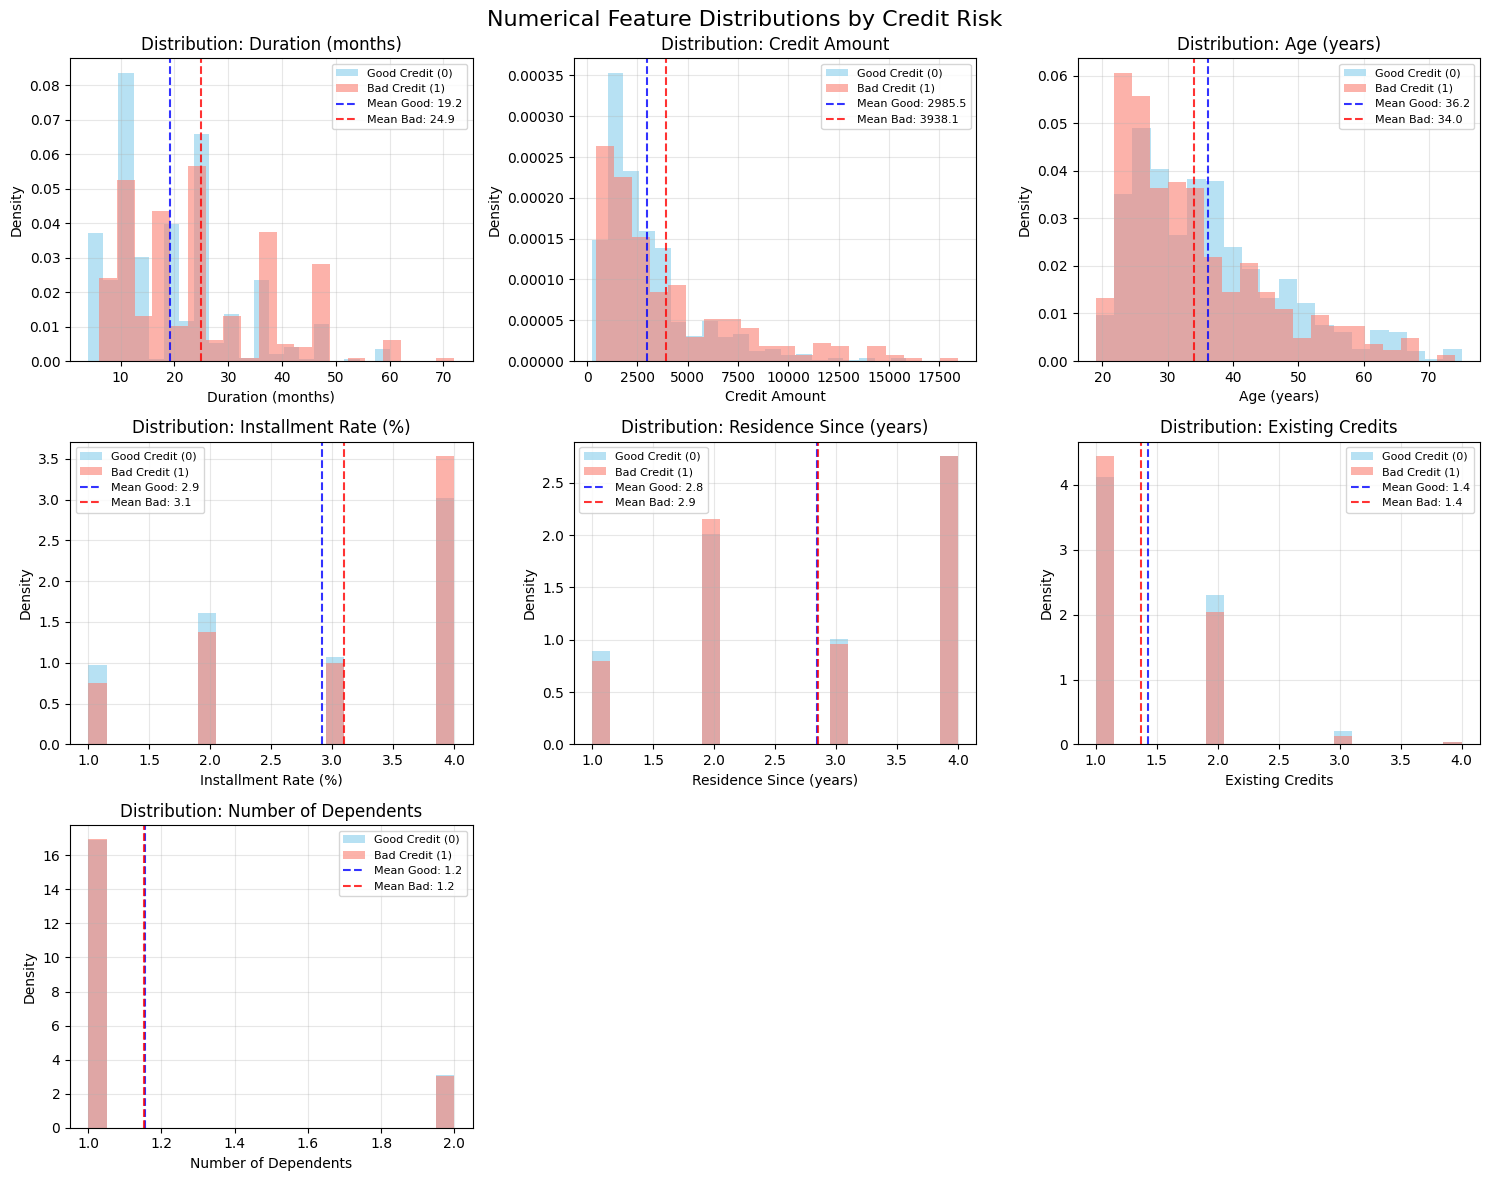

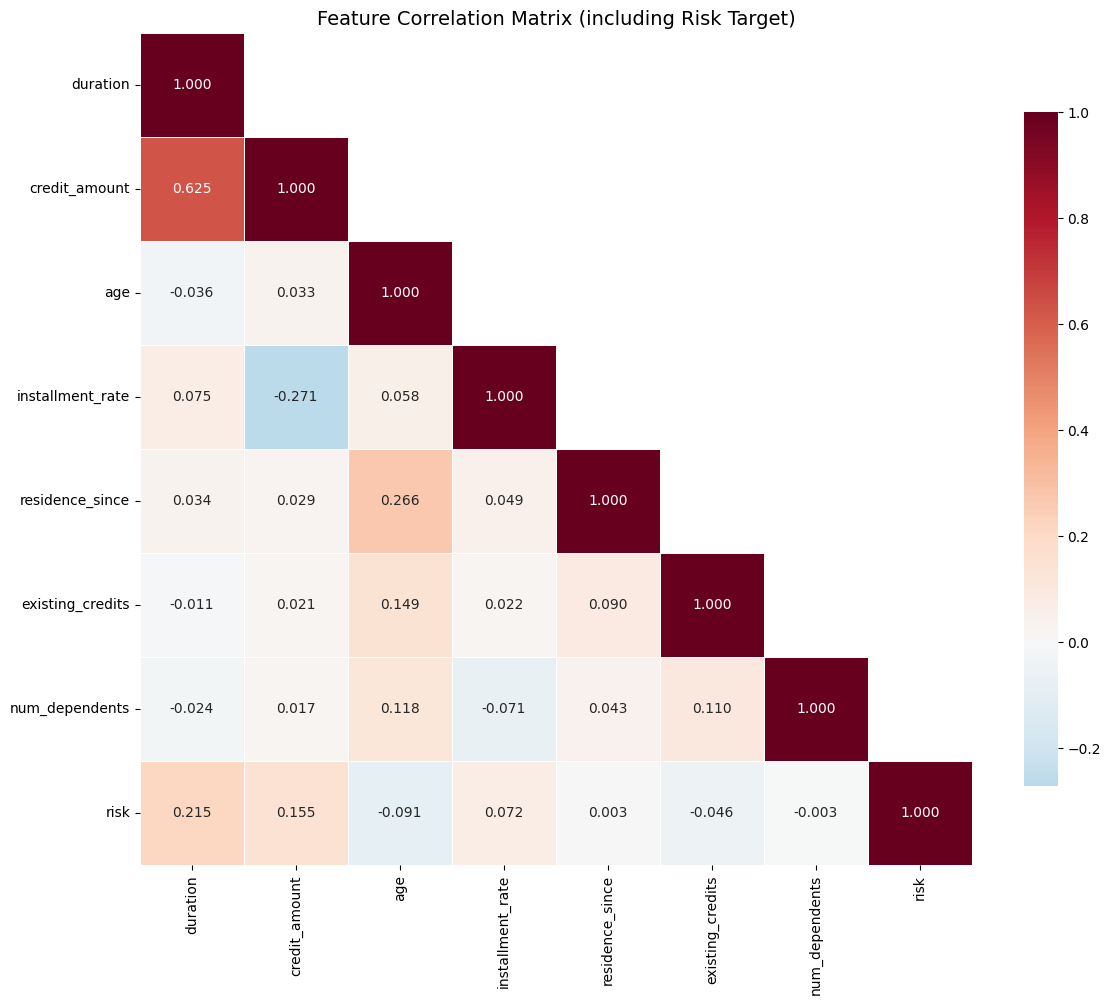


FEATURE-TARGET CORRELATIONS
Duration (months)        :  0.215
Credit Amount            :  0.155
Age (years)              : -0.091
Installment Rate (%)     :  0.072
Existing Credits         : -0.046
Number of Dependents     : -0.003
Residence Since (years)  :  0.003

No highly correlated feature pairs found (>0.9)


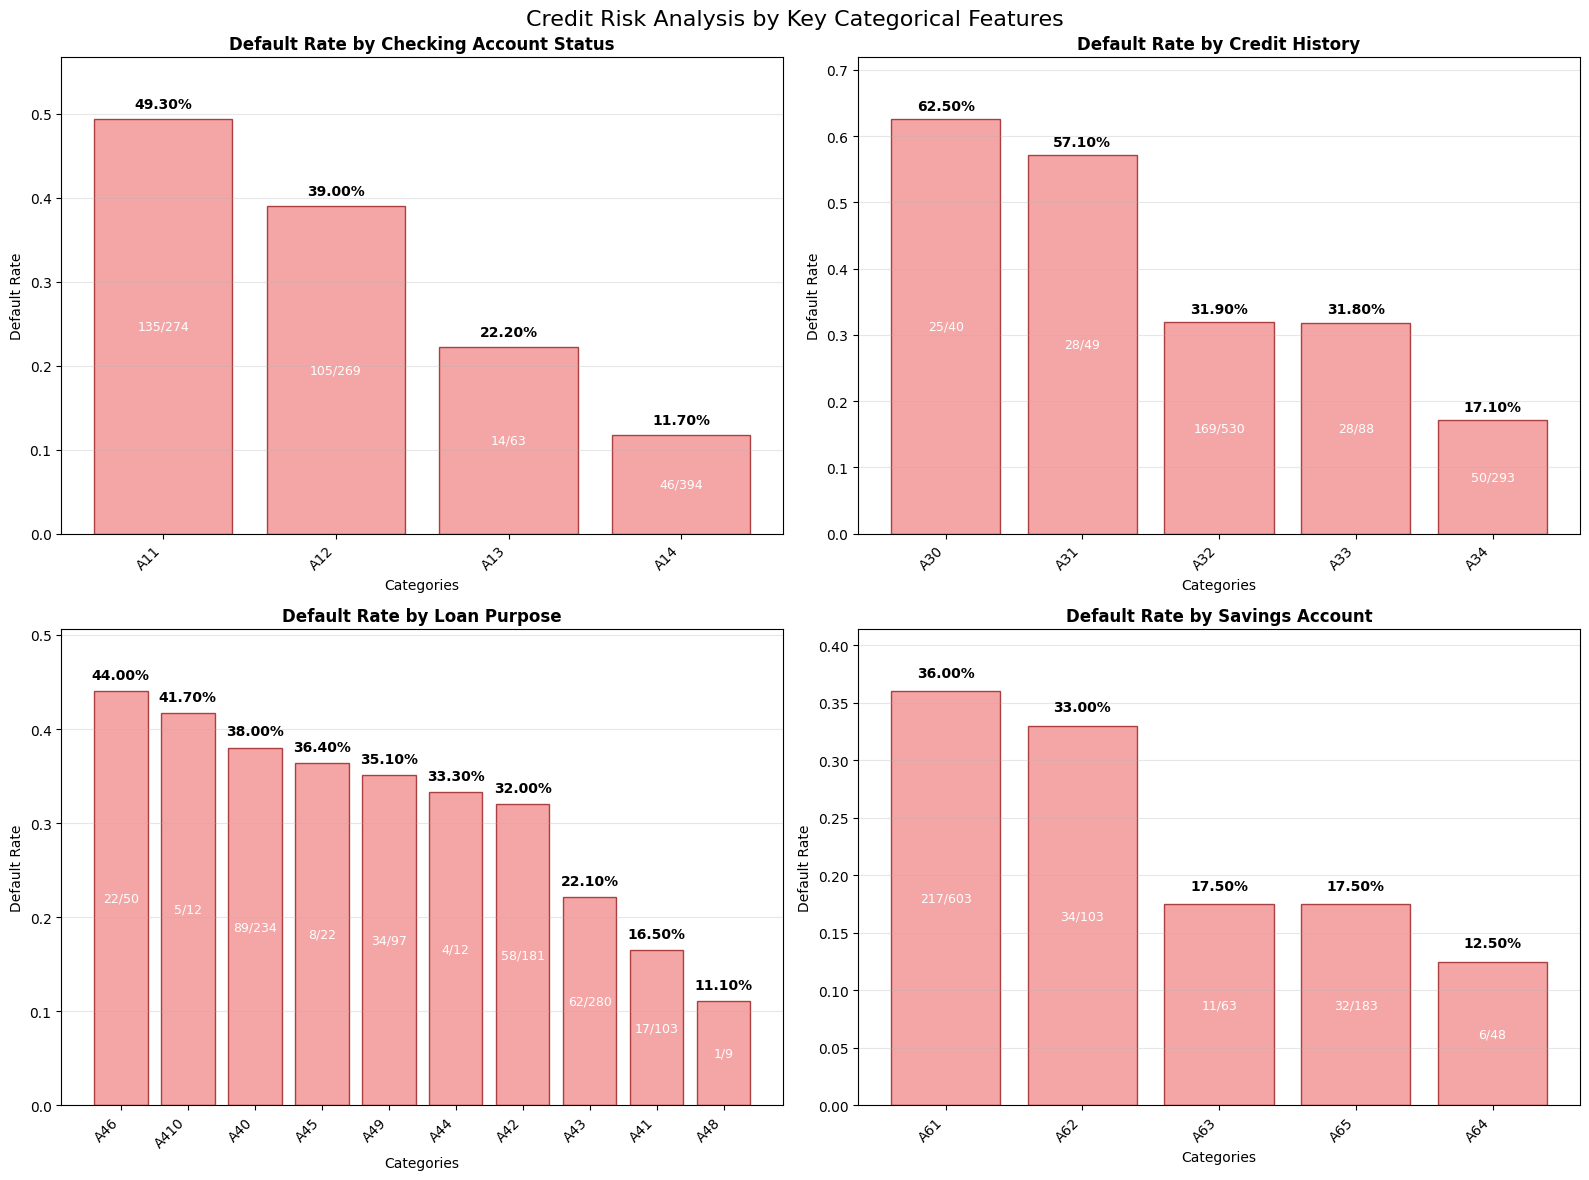


DETAILED RISK ANALYSIS BY CATEGORICAL FEATURES

CHECKING ACCOUNT STATUS:
--------------------------------------------------
  A11            : 135/274 (49.3%)
  A12            : 105/269 (39.0%)
  A13            :  14/ 63 (22.2%)
  A14            :  46/394 (11.7%)

CREDIT HISTORY:
--------------------------------------------------
  A30            :  25/ 40 (62.5%)
  A31            :  28/ 49 (57.1%)
  A32            : 169/530 (31.9%)
  A33            :  28/ 88 (31.8%)
  A34            :  50/293 (17.1%)

LOAN PURPOSE:
--------------------------------------------------
  A46            :  22/ 50 (44.0%)
  A410           :   5/ 12 (41.7%)
  A40            :  89/234 (38.0%)
  A45            :   8/ 22 (36.4%)
  A49            :  34/ 97 (35.1%)
  A44            :   4/ 12 (33.3%)
  A42            :  58/181 (32.0%)
  A43            :  62/280 (22.1%)
  A41            :  17/103 (16.5%)
  A48            :   1/  9 (11.1%)

SAVINGS ACCOUNT:
--------------------------------------------------
  A61  

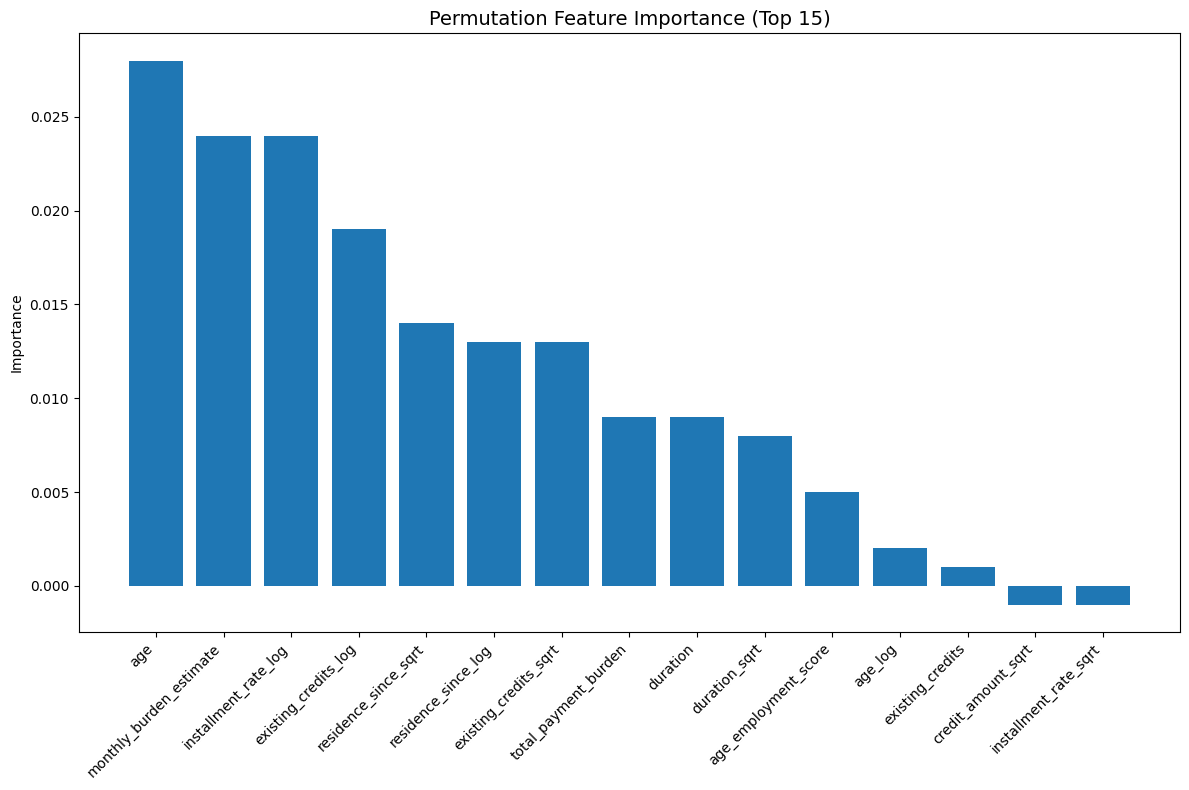


Top 10 Most Important Features (Permutation Importance):
--------------------------------------------------
 1. age                       (0.0280)
 2. monthly_burden_estimate   (0.0240)
 3. installment_rate_log      (0.0240)
 4. existing_credits_log      (0.0190)
 5. residence_since_sqrt      (0.0140)
 6. residence_since_log       (0.0130)
 7. existing_credits_sqrt     (0.0130)
 8. total_payment_burden      (0.0090)
 9. duration                  (0.0090)
10. duration_sqrt             (0.0080)

INDIVIDUAL PREDICTION EXPLANATIONS

Sample 86:
  Actual Label: Low Risk
  Prediction: High Risk
  Probability: 0.593
  Correct: No
  Feature Values:
    duration: -0.125
    credit_amount: -0.426
    age: -0.462
    existing_credits: 0.000
    total_payment_burden: 0.283

Sample 10:
  Actual Label: Low Risk
  Prediction: Low Risk
  Probability: 0.453
  Correct: Yes
  Feature Values:
    duration: 1.000
    credit_amount: -0.008
    age: 0.538
    existing_credits: 0.000
    total_payment_burden:

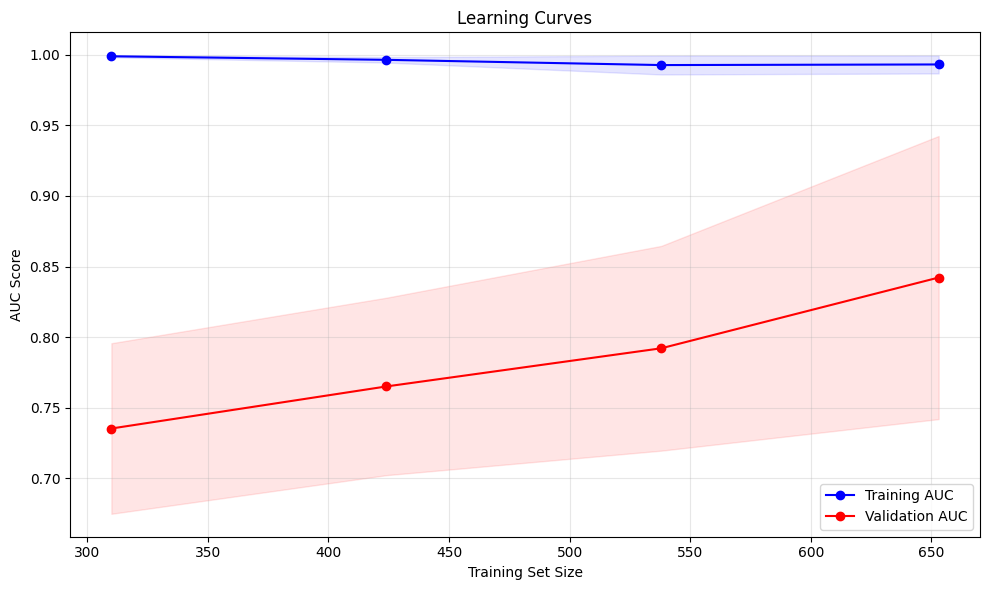

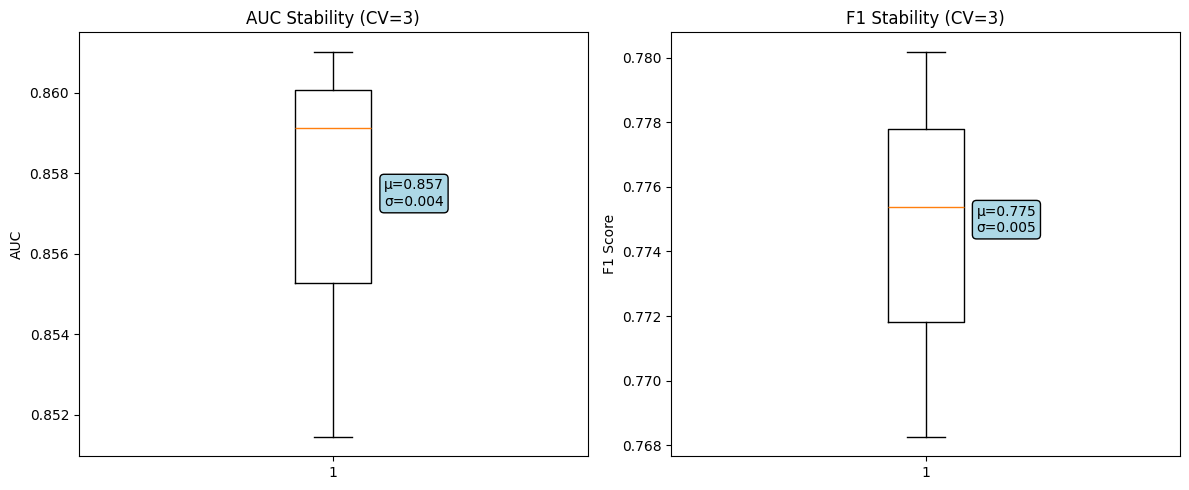

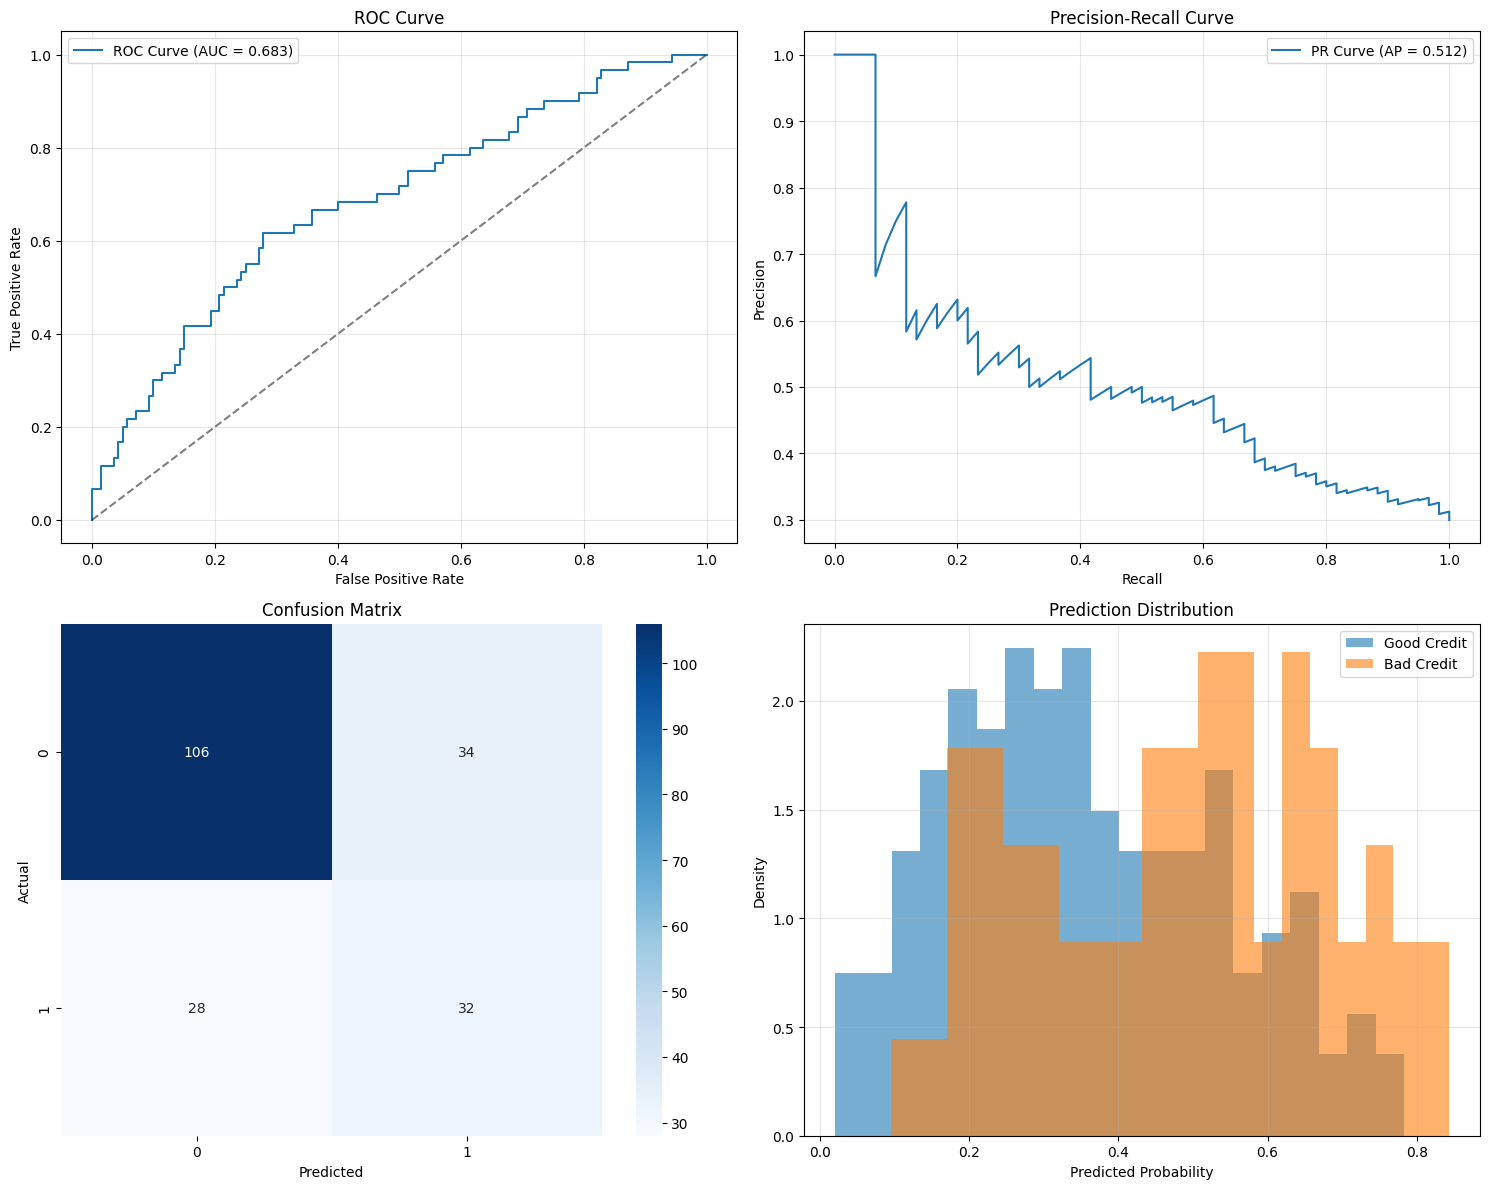


                    CREDIT RISK PREDICTION MODEL - FINAL REPORT

PROJECT SUMMARY:
- Total Samples: 1000
- Features Used: 20 (after feature selection)
- Default Rate: 30.00%
- Best Model: Ensemble

PERFORMANCE METRICS (Test Set):
- AUC Score: 0.683
- Precision: 0.326
- Recall: 0.983
- F1 Score: 0.490
- Specificity: 0.129

BUSINESS METRICS:
- Total Cost: $127.00
- Cost per Prediction: $0.64
- False Positives: 122 (rejected good loans)
- False Negatives: 1 (approved bad loans)
- True Positives: 59 (correctly identified bad loans)
- True Negatives: 18 (correctly approved good loans)

MODEL RECOMMENDATIONS:
1. Deploy Ensemble as the primary scoring model
2. Set probability threshold to 0.3 for conservative approach
3. Monitor model performance monthly for drift detection
4. Retrain model quarterly or when performance degrades
5. Implement A/B testing framework for model updates

FILES GENERATED:
- Model artifacts: models/credit_risk_model_artifacts.pkl
- Results plots: results/*.png
- Mode

In [ ]:
def main():
    """Updated main execution pipeline with better error handling"""
    logger.info("Starting Credit Risk Prediction Pipeline")

    try:
        # 1. Load Data
        logger.info("Step 1: Loading data...")
        df = load_german_credit_data()
        validate_german_credit_data(df)

        # 2. Exploratory Data Analysis
        logger.info("Step 2: Performing EDA...")
        eda = CreditRiskEDA(df)
        eda_results = eda.run_complete_eda()

        # 3. Feature Engineering
        logger.info("Step 3: Feature engineering...")
        engineer = FeatureEngineer(df)
        engineered_df = (engineer
                        .create_interaction_features()
                        .create_polynomial_features()
                        .create_binning_features()
                        .create_domain_specific_features()
                        .handle_outliers(method='clip')
                        .encode_categorical_features()
                        .get_engineered_data())

        logger.info(f"Feature engineering completed. Final dataset shape: {engineered_df.shape}")

        # 4. Model Building
        logger.info("Step 4: Building models...")
        model_builder = CreditRiskModel(engineered_df)
        (model_builder
         .prepare_data(scale=True, handle_imbalance=True)
         .feature_selection(method='mutual_info', k=min(20, engineered_df.shape[1]-1))
         .train_baseline_models())

        # Only do hyperparameter tuning if we have successful models
        if model_builder.models:
            model_builder.hyperparameter_tuning(model_name='XGBoost')
            model_builder.create_ensemble_model()
        else:
            logger.error("No models were successfully trained. Exiting.")
            return None, None

        # 5. Model Evaluation
        logger.info("Step 5: Evaluating models...")
        report = model_builder.generate_model_report()

        if model_builder.results:
            final_metrics = model_builder.evaluate_final_model()
        else:
            logger.error("No models available for evaluation")
            return None, None

        # 6. Model Interpretation
        logger.info("Step 6: Interpreting model...")
        best_model_name = max(model_builder.results.keys(), key=lambda x: model_builder.results[x]['auc'])
        best_model = model_builder.models[best_model_name]

        # Fixed initialization with all required parameters
        interpreter = ModelInterpreter(
            best_model,
            model_builder.X_train,
            model_builder.X_test,
            model_builder.y_test,  # Added y_test
            model_builder.X_train.columns.tolist()
        )
        interpreter.feature_importance_analysis()
        interpreter.generate_prediction_explanations(n_samples=3)

        # 7. Model Validation
        logger.info("Step 7: Validating model...")
        validator = ModelValidator(
            best_model,
            model_builder.X_train,
            model_builder.y_train,
            model_builder.X_test,
            model_builder.y_test
        )
        validator.learning_curve_analysis()
        validator.stability_analysis()
        validator.basic_validation_plots()

        # 8. Deployment Preparation
        logger.info("Step 8: Preparing for deployment...")
        deployment = ModelDeployment(
            best_model,
            model_builder.scaler,
            model_builder.feature_selector,
            model_builder.X_train.columns.tolist(),
            feature_engineer=engineer,  # Pass the feature engineer
            categorical_encoders=getattr(model_builder, 'categorical_encoders', {}),
            numerical_imputers=getattr(model_builder, 'numerical_imputers', {})
        )
        deployment.save_model_artifacts()

        # 9. Generate Final Report
        logger.info("Step 9: Generating final report...")
        generate_final_report(model_builder, final_metrics, best_model_name)

        logger.info("Credit Risk Prediction Pipeline completed successfully!")
        return model_builder, deployment

    except Exception as e:
        logger.error(f"Error in main pipeline: {str(e)}")
        raise


def generate_final_report(model_builder, final_metrics, best_model_name):
    """Generate comprehensive final report with error handling"""
    try:
        report = f"""
===============================================================================
                    CREDIT RISK PREDICTION MODEL - FINAL REPORT
===============================================================================

PROJECT SUMMARY:
- Total Samples: {len(model_builder.df)}
- Features Used: {model_builder.X_train.shape[1]} (after feature selection)
- Default Rate: {model_builder.df['risk'].mean():.2%}
- Best Model: {best_model_name}

PERFORMANCE METRICS (Test Set):
- AUC Score: {final_metrics.get('auc', 'N/A'):.3f}
- Precision: {final_metrics.get('precision', 'N/A'):.3f}
- Recall: {final_metrics.get('recall', 'N/A'):.3f}
- F1 Score: {final_metrics.get('f1', 'N/A'):.3f}
- Specificity: {final_metrics.get('specificity', 'N/A'):.3f}

BUSINESS METRICS:
- Total Cost: ${final_metrics.get('total_cost', 'N/A'):.2f}
- Cost per Prediction: ${final_metrics.get('cost_per_prediction', 'N/A'):.2f}
- False Positives: {final_metrics.get('fp', 'N/A')} (rejected good loans)
- False Negatives: {final_metrics.get('fn', 'N/A')} (approved bad loans)
- True Positives: {final_metrics.get('tp', 'N/A')} (correctly identified bad loans)
- True Negatives: {final_metrics.get('tn', 'N/A')} (correctly approved good loans)

MODEL RECOMMENDATIONS:
1. Deploy {best_model_name} as the primary scoring model
2. Set probability threshold to {Config.PROBABILITY_THRESHOLD} for conservative approach
3. Monitor model performance monthly for drift detection
4. Retrain model quarterly or when performance degrades
5. Implement A/B testing framework for model updates

FILES GENERATED:
- Model artifacts: {Config.MODEL_PATH}credit_risk_model_artifacts.pkl
- Results plots: {Config.RESULTS_PATH}*.png
- Model comparison: {Config.RESULTS_PATH}model_comparison.csv

Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
===============================================================================
        """

        # Save report
        report_path = f'{Config.RESULTS_PATH}final_report.txt'
        with open(report_path, 'w') as f:
            f.write(report)

        print(report)
        logger.info(f"Final report saved to {report_path}")

    except Exception as e:
        logger.error(f"Error generating final report: {str(e)}")


# Example usage
if __name__ == "__main__":
    try:
        model_builder, deployment = main()

        # # Example of making a prediction with the deployed model
        # if deployment:
        #     # Sample feature values for prediction (you would replace these with actual values)
        #     sample_features = {
        #         'duration': 12,
        #         'credit_amount': 5000,
        #         'age': 35,
        #         'installment_rate': 2,
        #         # Add other features as needed based on your selected features
        #     }

        #     prediction_result = deployment.predict_single(sample_features)
        #     print(f"\nSample Prediction Result: {prediction_result}")

    except Exception as e:
        logger.error(f"Pipeline execution failed: {str(e)}")
        print(f"Pipeline failed with error: {str(e)}")
        print("Please check the logs for detailed error information.")